In [1]:
from langgraph.graph import StateGraph,START,END
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI 
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
from typing import TypedDict , Literal , Annotated
import os
load_dotenv()
import operator

c:\Users\dell\Desktop\Langgraph-learning\agent\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.7) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\Users\dell\Desktop\Langgraph-learning\agent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.3)

In [3]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [4]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history : Annotated[list[str] , operator.add]
    feedback_history : Annotated[list[str] , operator.add]

In [5]:
# generate tweet node function
def generate_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    response = generator_llm.invoke(messages).content

    return {'tweet': response, 'tweet_history': [response]}

# evaluate tweet node function
def evaluate_tweet(state: TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback , 'feedback_history': [response.feedback]}

# optimize tweet node function
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration , 'tweet_history': [response]}

In [6]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [7]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

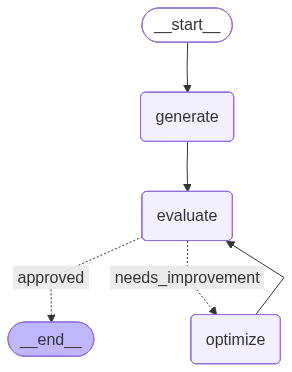

In [8]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [9]:
initial_state = {
    'topic': "The quirks of working from home",'max_iteration': 3}

final_state = workflow.invoke(initial_state)

In [10]:
print(final_state['tweet'])

My cat just judged my quarterly report. Her only feedback was a slow blink and a demand for more head scratches. Clearly, she understands true leadership.
